This notebook is to make a first pass estimate on the mass dependent bias we see when we start with a halo described by a Diemer profile (truncated NFW + 2-halo term), yet fit it with just an NFW halo model.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import numpy as np
import colossus.halo.profile_dk14 as dk14prof
import colossus.halo.profile_nfw as dnfwprof
import colossus.halo.concentration as chc
import colossus.cosmology.cosmology as ccosmo
from nfwfitter import nfwutils
import nfwfitter.nfwmodeltools as nfwtools
import readtxtfile

import nfwfitter.basicMassCon as bmc
import nfwfitter.colossusMassCon as cmc


In [3]:
curcosmo = nfwutils.global_cosmology

ccosmo.setCosmology('curCosmo', dict(H0 = curcosmo.H0,
                                        Om0 = curcosmo.omega_m,
                                        OL0 = curcosmo.omega_l,
                                        Ob0 = 0.049,
                                        sigma8 = 0.81,
                                        ns = 0.95))

In [4]:
def calcDiemerShearProfile(m200, zcluster, radii, zsource, density_profile_func = dk14prof.getDK14ProfileWithOuterTerms):
    #assuming source at infinite redshift
    #assuming Diemer M-c relation
        
        
    c200 = chc.concentration(m200, '200c', zcluster, model='diemer15')
        
    density_profile = density_profile_func(M=m200, c=c200, z=zcluster, mdef='200c')
        
    #Diemer radii are in units of kpc/h
    surfacedensity = density_profile.surfaceDensity(radii) #units are M_dot h/ kpc^2
    deltaSigma = density_profile.deltaSigma(radii)
        
    curcosmo = nfwutils.global_cosmology
    Dl = curcosmo.angulardist(zcluster)
    beta = curcosmo.beta([zsource], zcluster)
    sigma_crit = (curcosmo.v_c**2/(4*np.pi*curcosmo.G))/(Dl*beta)  #units are M_dot / Mpc^2
    convert_units = 1./(curcosmo.h*1e6)
    converted_sigma_crit = sigma_crit * convert_units
        
    gamma = deltaSigma/converted_sigma_crit
    kappa = surfacedensity/converted_sigma_crit
        
    g = gamma/(1-kappa)
        
    return g

In [5]:
def calcNFWShearProfile(m200, c200, zcluster, radii, zsource):
    #m200 is in M/h
    #radii are in kpc/h
    
    cosmo = nfwutils.global_cosmology
    
    
    converted_radii = radii/1000./cosmo.h
    
    rho_c_over_sigma_c = 1.5 * cosmo.angulardist(zcluster) * cosmo.beta([1e6], zcluster)[0] * cosmo.hubble2(zcluster) / cosmo.v_c**2
    
    rscale = nfwutils.rscaleConstM(m200/cosmo.h, c200, zcluster, 200.)
    
    gamma = nfwtools.NFWShear(converted_radii, c200, rscale, rho_c_over_sigma_c, 200.)
    kappa = nfwtools.NFWKappa(converted_radii, c200, rscale, rho_c_over_sigma_c, 200.)
    
    beta_s = curcosmo.beta_s([zsource], zcluster)
    
    g = beta_s*gamma/(1-beta_s*kappa)
    
    return g

In [6]:
def calcSamplingNoiseProfile(radii, zcluster, ndensity, sigma_e = 0.25):
    #radii are in kpc/h
    
    cosmo = nfwutils.global_cosmology
    Dl = cosmo.angulardist(zcluster) #Mpc
    converted_radii = radii/1000./cosmo.h
    radii_arcmin = (converted_radii/Dl)*(180./np.pi)*60
    
    centers = (radii_arcmin[1:] + radii_arcmin[:-1])/2.
    dR = np.zeros_like(radii_arcmin)
    dR[1:-1] = centers[1:] - centers[:-1]
    dR[0] = 2*(centers[0] - radii_arcmin[0])
    dR[-1] = 2*(radii_arcmin[-1] - centers[-1])
    
    area = 2*np.pi*radii_arcmin*dR
    
    noise = sigma_e/(np.sqrt(area*ndensity))
    
    return noise

OK, so first test. The shear profiles should look similar if I use a Diemer M-C relation.

In [23]:
radii = np.arange(100., 3000., 10.)  #units of kpc/h
m200 = 1e14 #M_sol/h
zcluster = 1.0
zsource = 2.0
#c200 = chc.concentration(m200, '200c', zcluster, model='diemer15')
#c200 = duffy(m200, zcluster)
c200 = 4.

In [20]:
diemer_shear = calcDiemerShearProfile(m200, zcluster, radii, zsource)

In [24]:
nfw_shear = calcNFWShearProfile(m200, c200, zcluster, radii, zsource)

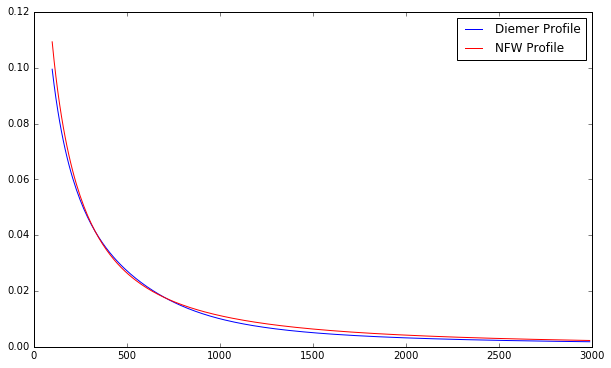

In [25]:
plt.plot(radii, diemer_shear, 'b-', label='Diemer Profile')
plt.plot(radii, nfw_shear, 'r-', label='NFW Profile')
plt.legend()

If I'm interacting with Diemer's code correctly, I should be able to compute an NFW shear and have it match.

In [11]:
nfw_shear_from_diemer = calcDiemerShearProfile(m200, zcluster, radii, zsource, density_profile_func = dnfwprof.NFWProfile)

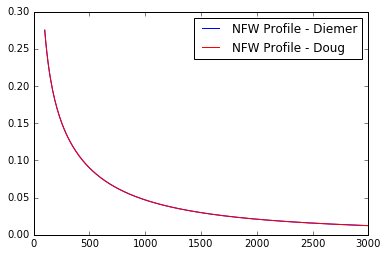

In [16]:
plt.plot(radii, nfw_shear_from_diemer, 'b-', label='NFW Profile - Diemer')
plt.plot(radii, nfw_shear, 'r-', label='NFW Profile - Doug')
plt.legend()

I find it interesting that the NFW and Diemer shear profiles cross twice for this mass. Is that consistent with the picture from BK11? What is the difference vs radius vs mass?

In [23]:
masses = np.logspace(np.log10(1e14), np.log10(3e15), 6)
diemer_shear = np.zeros((len(radii), len(masses)))
nfw_shear = np.zeros_like(diemer_shear)
for curmass in range(len(masses)):
    m200 = masses[curmass]
    diemer_shear[:,curmass] = calcDiemerShearProfile(m200, zcluster, radii, zsource)
    c200 = chc.concentration(m200, '200c', zcluster, model='diemer15')
    nfw_shear[:,curmass] = calcNFWShearProfile(m200, c200, zcluster, radii, zsource)
profile_ratio = diemer_shear / nfw_shear

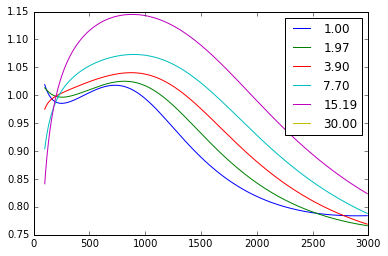

In [24]:
for curmass in range(len(masses)):
    plt.plot(radii, profile_ratio[:,curmass], label='{:.2f}'.format(masses[curmass]/1e14))
plt.legend()

Next step is to take these profile differences & feed it through a chi-sq fit, to see how parameter values shift for a given noise source and radial fit range.

Need to now calculate the $\Chi^2$-weighted bias.

To save some power and time, will precompute shear profiles

In [7]:
c4 = bmc.constant()
c4.configure(dict(concentration=4.))

duffy = bmc.Duffy()

diemer = cmc.ColossusMC()
diemer.configure(dict(colossusmcname = 'diemer15'))

In [8]:
def precomputeDiemer(radii, zcluster, zsource, m200s = np.array([1e14, 3e14, 5e14, 7e14, 9e14, 1.1e15, 2.1e15])):
    
    diemerprofiles = {}
    for m200 in m200s:
        diemerprofiles[m200] = calcDiemerShearProfile(m200, zcluster, radii, zsource)
    return diemerprofiles

In [9]:
def precomputeNFW(radii, zcluster, zsource, m200s = np.arange(1.01e13, 4e15, 1e12), masscon = diemer):
    
    nfwprofiles = {}
    for m200 in m200s:
        c200 = masscon(m200, zcluster)
        nfwprofiles[m200] = calcNFWShearProfile(m200, c200, zcluster, radii, zsource)
        
    return nfwprofiles

In [10]:
m200_trues = m200s = np.array([1e14, 3e14, 5e14, 7e14, 9e14, 1.1e15, 2.1e15])
massscan = np.arange(1.01e13, 4e15, 1e12)

def computeBias(radii, zcluster, zsource, ndensity=10., masscon=diemer, noiseprofile = None, delta = 200.):
    
    
    
    diemerprofiles = precomputeDiemer(radii, zcluster, zsource, m200s = m200_trues)
    nfwprofiles = precomputeNFW(radii, zcluster, zsource, m200s = massscan, masscon = masscon)
    
    if noiseprofile is not None:
        print 'NOISE GIVEN'
        noise = noiseprofile
    else:
        print 'NOISE CALCULATED'
        noise = calcSamplingNoiseProfile(radii, zcluster, ndensity)
    
    
    nfwgrid = np.zeros((m200_trues.shape[0], massscan.shape[0], radii.shape[0]))
    diemergrid = np.zeros_like(nfwgrid)
    noisegrid = np.zeros_like(nfwgrid)

    for curtrue in range(m200_trues.shape[0]):
        for curscan in range(massscan.shape[0]):
            nfwgrid[curtrue, curscan,:] = nfwprofiles[massscan[curscan]]
            diemergrid[curtrue, curscan,:] = diemerprofiles[m200_trues[curtrue]]
            noisegrid[curtrue,curscan,:] = noise
        
    chisqs = np.sum(((diemergrid - nfwgrid)/noisegrid)**2, axis=2)
    assert(chisqs.shape == (m200_trues.shape[0], massscan.shape[0]))

    #maxlike bias

    maxlike_mass = np.zeros_like(m200_trues)

    maxlike_recon_mass = massscan[np.argmin(chisqs, axis=1)]
    maxlike_bias = maxlike_recon_mass / m200_trues


    #average bias

    recon_mass_prob = np.exp(-0.5*chisqs)
    norm_mass_prob = np.trapz(recon_mass_prob, massscan, axis=1)
    recon_mass_prob = (recon_mass_prob.T/norm_mass_prob).T
    assert(norm_mass_prob.shape ==  m200_trues.shape)
    recon_ave_mass = np.trapz(recon_mass_prob*massscan, massscan, axis=1)

    ave_bias = recon_ave_mass / m200_trues

    return maxlike_bias, ave_bias

First, let's mock up NFW(mc=diemer) vs Diemer at z=0.25

In [38]:
ave_bias, maxlike_bias = computeBias(np.arange(750., 3000., 100.), 0.25, 1.0, 10., diemer)

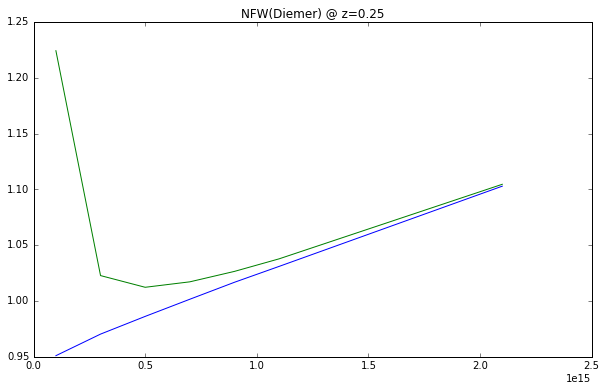

In [39]:
plt.plot(m200_trues, ave_bias, label='Ave')
plt.plot(m200_trues, maxlike_bias, label='Maxlike')
plt.title('NFW(Diemer) @ z=0.25')

Bias for WtG @ z=.25 using c=4

In [58]:
c4_maxlike_bias_highnoise, c4_ave_bias_highnoise = computeBias(np.arange(750., 3000., 100.), 0.25, 1.0, 2., c4)

NOISE CALCULATED


In [ ]:
c4_maxlike_bias, c4_ave_bias = computeBias(np.arange(750., 3000., 100.), 0.25, 1.0, 10., c4)

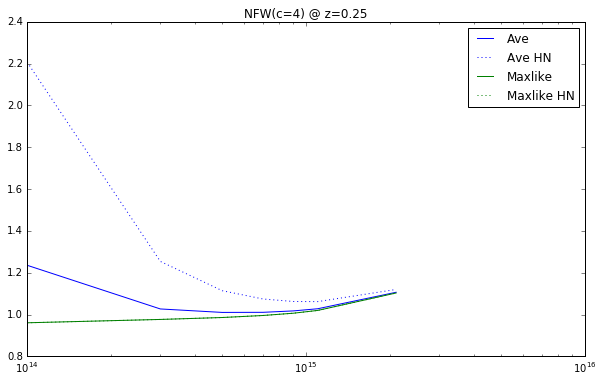

In [60]:
plt.semilogx(m200_trues, c4_ave_bias, 'b-', label='Ave')
plt.semilogx(m200_trues, c4_ave_bias_highnoise, 'b:', label='Ave HN')
plt.semilogx(m200_trues, c4_maxlike_bias, 'g-', label='Maxlike')
plt.semilogx(m200_trues, c4_maxlike_bias_highnoise, 'g:',label='Maxlike HN')
plt.title('NFW(c=4) @ z=0.25')
plt.legend()

Bias for WtG @ z=0.25 w/NFW(Duffy)

In [ ]:
duffy_ave_bias, duffy_maxlike_bias = computeBias(np.arange(750., 3000., 100.), 0.25, 1.0, 10., duffy)

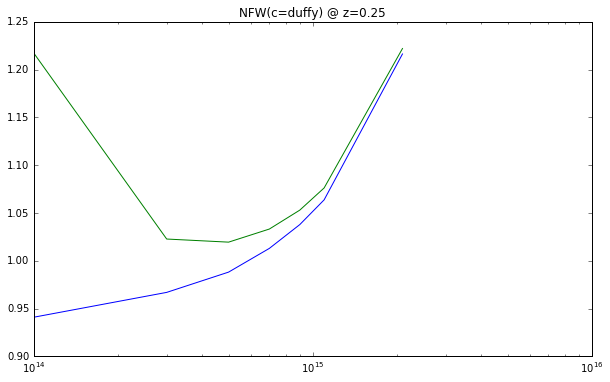

In [45]:
plt.semilogx(m200_trues, duffy_ave_bias, label='Ave')
plt.semilogx(m200_trues, duffy_maxlike_bias, label='Maxlike')
plt.title('NFW(c=duffy) @ z=0.25')

Let's look at HST range

In [51]:
hst_ave_bias_c4, hst_maxlike_bias_c4 = computeBias(np.arange(500., 1500., 100.), 1.0, 2.0, 5., c4)
hst_ave_bias_duffy, hst_maxlike_bias_duffy = computeBias(np.arange(500., 1500., 100.), 1.0, 2.0, 5., duffy)

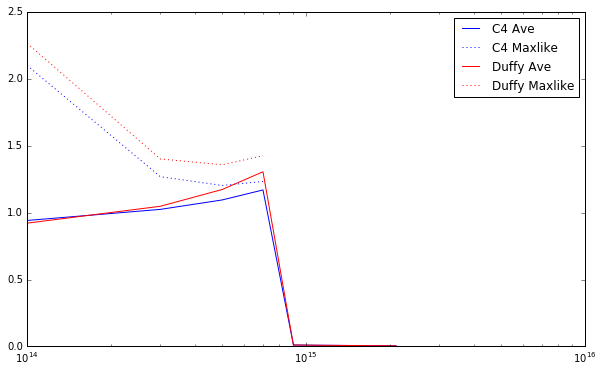

In [52]:
plt.semilogx(m200_trues, hst_ave_bias_c4, 'b-', label='C4 Ave')
plt.semilogx(m200_trues, hst_maxlike_bias_c4, 'b:', label='C4 Maxlike')
plt.semilogx(m200_trues, hst_ave_bias_duffy, 'r-', label='Duffy Ave')
plt.semilogx(m200_trues, hst_maxlike_bias_duffy, 'r:', label='Duffy Maxlike')
plt.legend()

Now, what happens if I use an HST noise profile to weight the core of the cluster?

In [15]:
hst_profile = readtxtfile.readtxtfile('/Users/dapple/astro/mxxlsims/data/shearprofiles/SPT-CLJ0000-5748.szcenter.profile')
bincenters = np.array([x[0] for x in hst_profile])
deltag = np.array([x[2] for x in hst_profile])


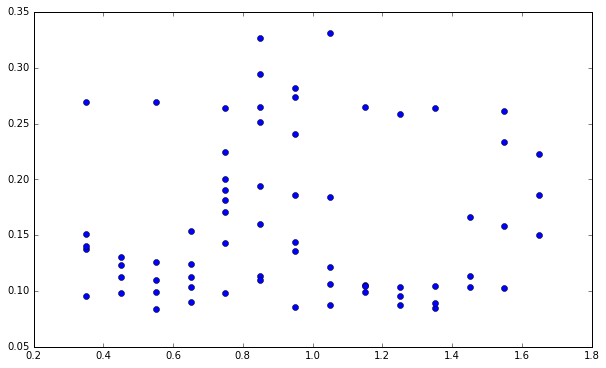

In [16]:
plt.plot(bincenters, deltag, 'bo')

In [17]:
hst_ave_bias_c4, hst_maxlike_bias_c4 = computeBias(bincenters*1000*nfwutils.global_cosmology.h, 0.75, 1.5, masscon = c4, noiseprofile = deltag)

/Users/dapple/anaconda/lib/python2.7/site-packages/colossus-1.0.3-py2.7.egg/colossus/halo/profile_base.py:629: RuntimeWarning: divide by zero encountered in log
  table_log_rho = np.log(density_func(np.exp(table_log_r)))
/Users/dapple/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


NOISE GIVEN


In [18]:
hst_ave_bias_duffy, hst_maxlike_bias_duffy = computeBias(bincenters*1000*nfwutils.global_cosmology.h, 0.75, 1.5, masscon = duffy, noiseprofile = deltag)

NOISE GIVEN


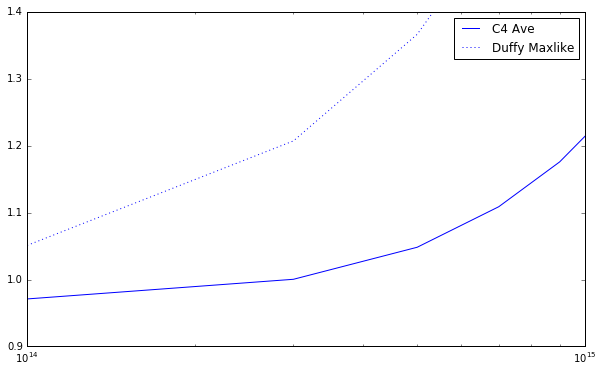

In [19]:
plt.semilogx(m200_trues, hst_ave_bias_c4, 'b-', label='C4 Ave')
plt.semilogx(m200_trues, hst_ave_bias_duffy, 'b:', label='Duffy Maxlike')
plt.axis([1e14, 1e15, 0.9, 1.4])
plt.legend()

how does this change for m500?

How do these curves change when I match the MXXL cosmology?

In [13]:
mxxlcosmo = nfwutils.Cosmology(omega_m = 0.25, omega_l = 0.75, h=0.73)
nfwutils.global_cosmology.set_cosmology(mxxlcosmo)
curcosmo = nfwutils.global_cosmology

ccosmo.setCosmology('curCosmo', dict(H0 = curcosmo.H0,
                                        Om0 = curcosmo.omega_m,
                                        OL0 = curcosmo.omega_l,
                                        Ob0 = 0.049,
                                        sigma8 = 0.81,
                                        ns = 0.95))

In [17]:
hst_ave_bias_c4, hst_maxlike_bias_c4 = computeBias(bincenters*1000*nfwutils.global_cosmology.h, 0.75, 1.5, masscon = c4, noiseprofile = deltag)


/Users/dapple/anaconda/lib/python2.7/site-packages/colossus-1.0.3-py2.7.egg/colossus/halo/profile_base.py:629: RuntimeWarning: divide by zero encountered in log
  table_log_rho = np.log(density_func(np.exp(table_log_r)))
/Users/dapple/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


NOISE GIVEN


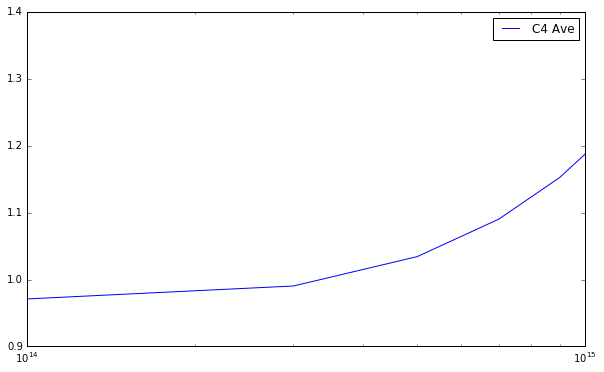

In [18]:
plt.semilogx(m200_trues, hst_ave_bias_c4, 'b-', label='C4 Ave')
plt.axis([1e14, 1e15, 0.9, 1.4])
plt.legend()

Does this change with other cluster profiles?

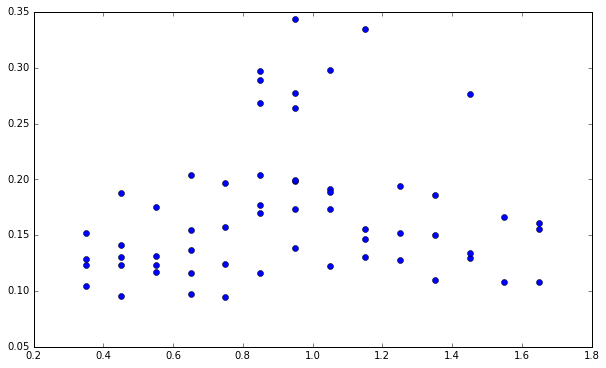

In [19]:
hst_profile = readtxtfile.readtxtfile('/Users/dapple/astro/mxxlsims/data/shearprofiles/SPT-CLJ2040-5725.szcenter.profile')
bincenters = np.array([x[0] for x in hst_profile])
deltag = np.array([x[2] for x in hst_profile])
plt.plot(bincenters, deltag, 'bo')

In [20]:
hst_ave_bias_c4, hst_maxlike_bias_c4 = computeBias(bincenters*1000*nfwutils.global_cosmology.h, 0.75, 1.5, masscon = c4, noiseprofile = deltag)


NOISE GIVEN


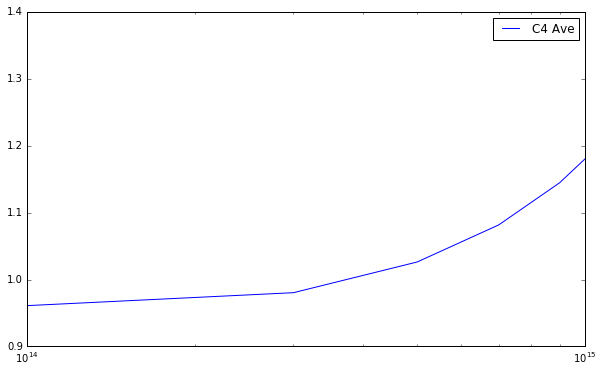

In [21]:
plt.semilogx(m200_trues, hst_ave_bias_c4, 'b-', label='C4 Ave')
plt.axis([1e14, 1e15, 0.9, 1.4])
plt.legend()

The match is close, but not quite. The upturn is happening at lower masses than I have evidence for from the simulations. Is this a case where the calculation is not applicable? I probably need to introduce noise to see how it perturbs things. That means running repeated sets. 

On the flip side, I know that in the full procedure, the noise level doesn't really matter. But maybe that's just because the noise profile describes the noise, but its perturbing effects are still there.

In [38]:
def computeBiasWithNoise(radii, mdelta, zcluster, zsource, ndensity=20., masscon=diemer, noiseprofile = None, delta = 200., nrealizations = 500):
    
    
    
    diemerprofile = precomputeDiemer(radii, zcluster, zsource, m200s = [mdelta])[mdelta]
    nfwprofiles = precomputeNFW(radii, zcluster, zsource, m200s = massscan, masscon = masscon)
    
    if noiseprofile is not None:
        print 'NOISE GIVEN'
        noise = noiseprofile
    else:
        print 'NOISE CALCULATED'
        noise = calcSamplingNoiseProfile(radii, zcluster, ndensity)
    
    
    nfwgrid = np.zeros((nrealizations, massscan.shape[0], radii.shape[0]))
    diemergrid = np.zeros_like(nfwgrid)
    noisegrid = np.zeros_like(nfwgrid)

    for curiter in range(nrealizations):
        inputprofile = diemerprofile + noise*np.random.standard_normal(size=len(radii))
        for curscan in range(massscan.shape[0]):
            nfwgrid[curiter, curscan,:] = nfwprofiles[massscan[curscan]]
            diemergrid[curiter, curscan,:] = inputprofile
            noisegrid[curiter,curscan,:] = noise
        
    chisqs = np.sum(((diemergrid - nfwgrid)/noisegrid)**2, axis=2)
    assert(chisqs.shape == (nrealizations, massscan.shape[0]))

    #maxlike bias

    maxlike_recon_mass = massscan[np.argmin(chisqs, axis=1)]
    maxlike_bias = maxlike_recon_mass / mdelta


    #average bias

    recon_mass_prob = np.exp(-0.5*chisqs)
    norm_mass_prob = np.trapz(recon_mass_prob, massscan, axis=1)
    recon_mass_prob = (recon_mass_prob.T/norm_mass_prob).T
    assert(norm_mass_prob.shape ==  (nrealizations,))
    recon_ave_mass = np.trapz(recon_mass_prob*massscan, massscan, axis=1)

    ave_bias = recon_ave_mass / mdelta

    return recon_mass_prob, maxlike_bias, ave_bias

In [55]:
massbin = 2
probs, maxlike_bias_distro, ave_bias_distro = computeBiasWithNoise(np.arange(750., 3000., 100.), m200_trues[massbin], 0.75, 1.5, ndensity = 20, masscon = c4)


NOISE CALCULATED


0.952536 0.9862
0.977822900801 1.01055572062


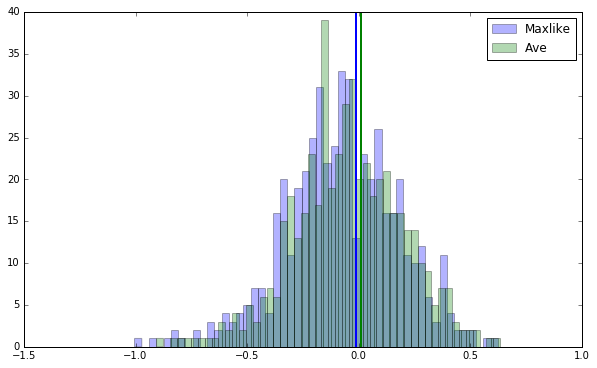

In [56]:


plt.hist(np.log(maxlike_bias_distro), bins=50, label='Maxlike', alpha=0.3)
plt.hist(np.log(ave_bias_distro), bins=50, label='Ave', alpha=0.3)
plt.legend()
plt.axvline(np.log(c4_maxlike_bias[massbin]), c='b', linewidth=2)
plt.axvline(np.log(c4_ave_bias[massbin]), c='g', linewidth=2)
c4_maxlike_bias, c4_ave_bias

print np.mean(maxlike_bias_distro), c4_maxlike_bias[massbin]
print np.mean(ave_bias_distro), c4_ave_bias[massbin]



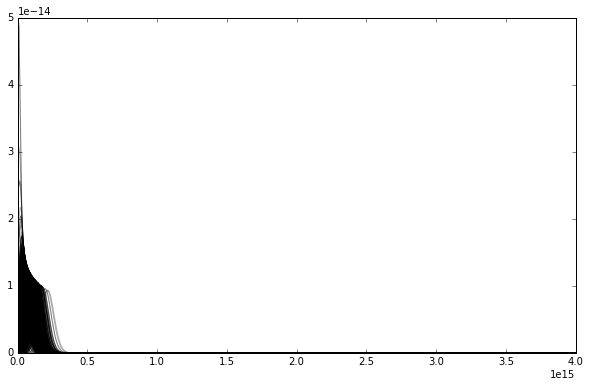

In [48]:
for i in range(probs.shape[0]):
    plt.plot(massscan, probs[i,:], 'k-', alpha=0.3)